In [1]:
from robustbench.data import load_cifar10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchattacks

In [3]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

# Data loading and preprocessing
def load_cifar10():
    # Simple data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
    
    # No augmentation for test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )
    return trainloader, testloader

In [4]:
trainloader, testloader = load_cifar10()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:06<00:00, 27.3MB/s]


In [5]:
model = SimpleCNN(num_classes=10)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,638,794


In [8]:
# Training function
def train_model(model, trainloader, num_epochs=10):
    device = 'mps'
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            out = model(inputs)

            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()

            if batch_idx % 10 != 0:
                running_loss += loss.item()
                _, predicted = out.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 99:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

In [9]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=5)


Starting training...
Training on mps
Epoch: 1/5, Batch: 99, Loss: 1.8600, Acc: 24.35%
Epoch: 1/5, Batch: 199, Loss: 1.6958, Acc: 29.46%
Epoch: 1/5, Batch: 299, Loss: 1.5390, Acc: 32.88%
Epoch 1 completed: Loss: 1.5708, Accuracy: 35.45%
Epoch: 2/5, Batch: 99, Loss: 1.3528, Acc: 47.50%
Epoch: 2/5, Batch: 199, Loss: 1.5369, Acc: 49.07%
Epoch: 2/5, Batch: 299, Loss: 1.2891, Acc: 50.33%
Epoch 2 completed: Loss: 1.1951, Accuracy: 51.40%
Epoch: 3/5, Batch: 99, Loss: 1.1975, Acc: 57.80%
Epoch: 3/5, Batch: 199, Loss: 1.0348, Acc: 58.94%
Epoch: 3/5, Batch: 299, Loss: 1.0763, Acc: 60.00%
Epoch 3 completed: Loss: 0.9844, Accuracy: 60.70%
Epoch: 4/5, Batch: 99, Loss: 0.9297, Acc: 63.23%
Epoch: 4/5, Batch: 199, Loss: 0.9540, Acc: 64.67%
Epoch: 4/5, Batch: 299, Loss: 1.0316, Acc: 65.16%
Epoch 4 completed: Loss: 0.8668, Accuracy: 65.57%
Epoch: 5/5, Batch: 99, Loss: 0.9726, Acc: 69.50%
Epoch: 5/5, Batch: 199, Loss: 0.7790, Acc: 69.56%
Epoch: 5/5, Batch: 299, Loss: 0.8778, Acc: 69.85%
Epoch 5 completed

In [11]:
def show_adv_examples(adv_images):
    # Show first 4 examples (or less if batch is smaller)
    num_to_show = min(4, adv_images.shape[0])
    
    fig, axes = plt.subplots(1, num_to_show, figsize=(12, 3))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        # Convert from (C, H, W) to (H, W, C) and move to CPU
        img = adv_images[i].permute(1, 2, 0).cpu().detach()
        
        # Clip values to [0, 1] range for display
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Adv Example {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

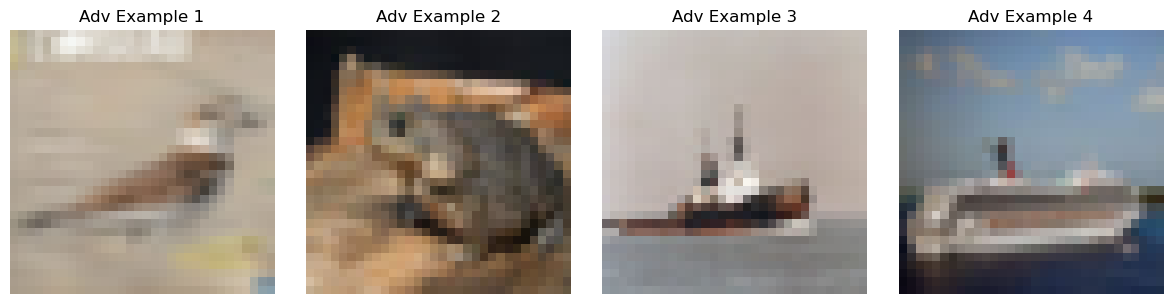

tensor([0, 0, 0, 0, 0], device='mps:0')
Attack success rate: 100.00%
5


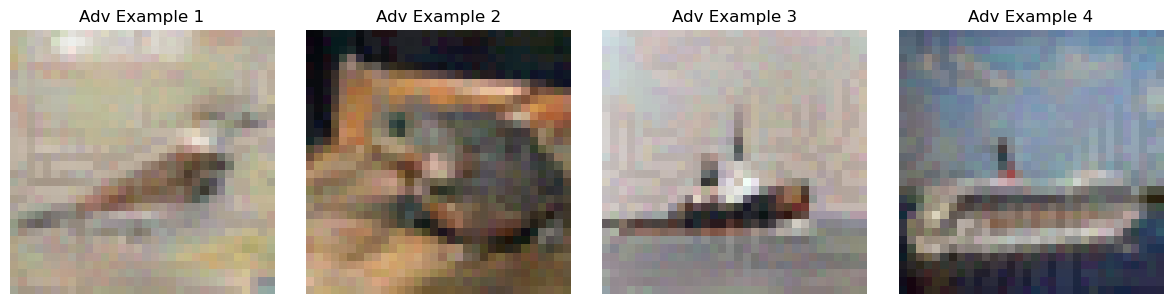

In [12]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[70:75], labels.to(device)[70:75]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

In [ ]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1.5, kappa=0, steps=200)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)